# Set Up

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

import math
import shap

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier

from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn import tree

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Importación y entendimiento de la data

In [2]:
url = 'https://raw.githubusercontent.com/fvelam/FIN14-financial-econometrics-project/refs/heads/main/bank/bank.csv'
df = pd.read_csv(url, sep=";")

print(df.shape) # el df utilizado ya es una muestra del dataset original. Tenemos 4521 registros y 16 regresores.
df.head()

(4521, 17)


,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,30,unemployed,married,primary,no,1787,no,no,cellular,19,oct,79,1,-1,0,unknown,no
1,33,services,married,secondary,no,4789,yes,yes,cellular,11,may,220,1,339,4,failure,no
2,35,management,single,tertiary,no,1350,yes,no,cellular,16,apr,185,1,330,1,failure,no
3,30,management,married,tertiary,no,1476,yes,yes,unknown,3,jun,199,4,-1,0,unknown,no
4,59,blue-collar,married,secondary,no,0,yes,no,unknown,5,may,226,1,-1,0,unknown,no


In [3]:
df.dtypes # verificamos que el tipo de dato tenga coherencia con la variable

,0
age,int64
job,object
marital,object
education,object
default,object
balance,int64
housing,object
loan,object
contact,object
day,int64


In [4]:
df['y'].value_counts(normalize=True) # hay presencia de un desbalance de datos. Podemos corregir dicha estructura con un oversampling o hacer uso de stratify para evitar errores.

,proportion
y,
no,0.88476
yes,0.11524


In [5]:
df.isnull().sum(axis=0) # vemos que no hay valores faltantes

,0
age,0
job,0
marital,0
education,0
default,0
balance,0
housing,0
loan,0
contact,0
day,0


In [6]:
df[['age','balance','day','duration','campaign','pdays','previous']].describe(percentiles=[0.01, 0.05, 0.75, 0.95, 0.99]).T

,count,mean,std,min,1%,5%,50%,75%,95%,99%,max
age,4521.0,41.170095,10.576211,19.0,24.0,27.0,39.0,49.0,59.0,72.0,87.0
balance,4521.0,1422.657819,3009.638142,-3313.0,-671.4,-162.0,444.0,1480.0,6102.0,14194.6,71188.0
day,4521.0,15.915284,8.247667,1.0,2.0,3.0,16.0,21.0,30.0,31.0,31.0
duration,4521.0,263.961292,259.856633,4.0,10.2,31.0,185.0,329.0,763.0,1259.0,3025.0
campaign,4521.0,2.793630,3.109807,1.0,1.0,1.0,2.0,3.0,8.0,16.0,50.0
pdays,4521.0,39.766645,100.121124,-1.0,-1.0,-1.0,-1.0,-1.0,317.0,370.0,871.0
previous,4521.0,0.542579,1.693562,0.0,0.0,0.0,0.0,0.0,3.0,8.0,25.0


In [7]:
def Histogramas(columns, ncols, dataframe, figsize_value=(20, 15)):
    N_VARS = len(columns)
    N_COLS_VARS = ncols
    N_ROWS_VARS = math.ceil(N_VARS / N_COLS_VARS)

    fig, axs = plt.subplots(N_ROWS_VARS, N_COLS_VARS, figsize=figsize_value)
    plt.subplots_adjust(left=0.125, bottom=0.1, right=0.9, top=0.9,
                        wspace=0.3, hspace=0.3)

    axs = axs.flatten()

    for i, col in enumerate(columns):
        axs[i].hist(dataframe[col], bins=20)
        axs[i].set_title(col)

    for j in range(len(columns), len(axs)):
        fig.delaxes(axs[j])

    plt.show()

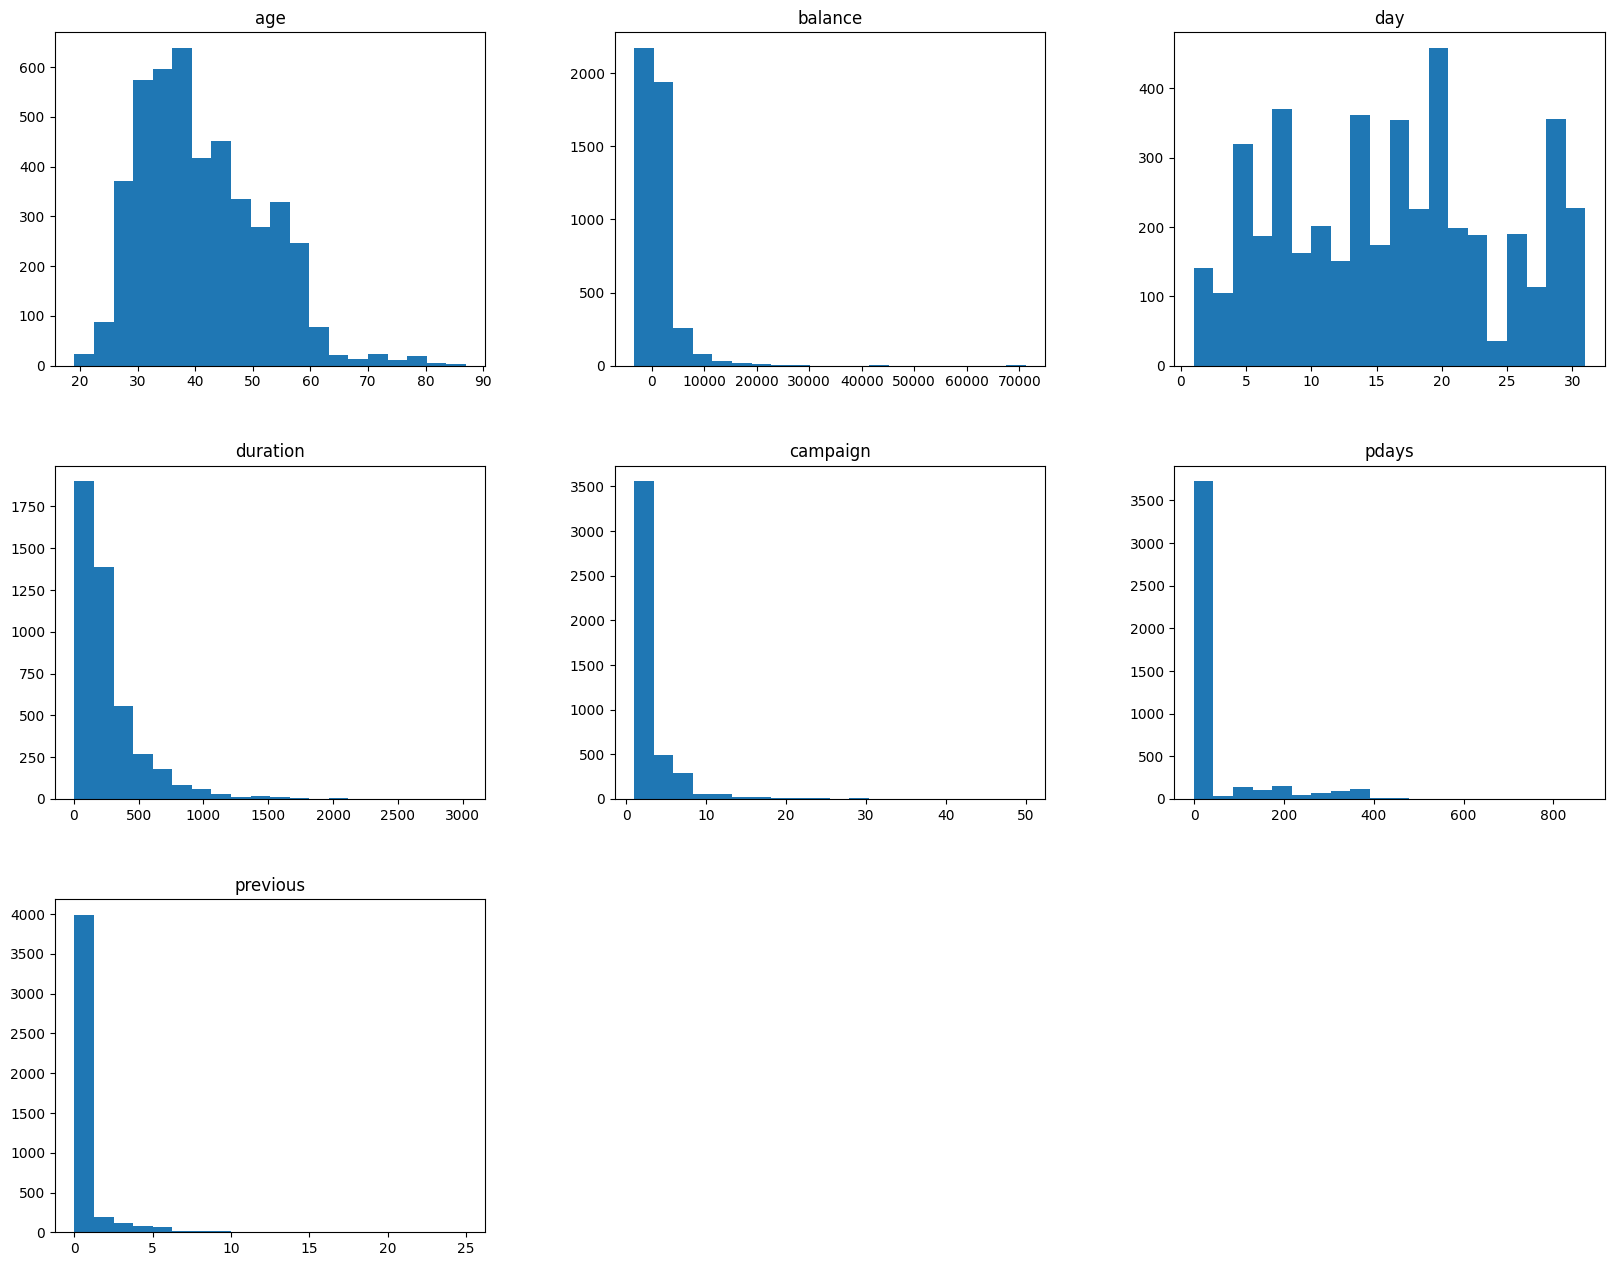

In [8]:
# Columnas numéricas del df
num = df.select_dtypes(include='number').columns
Histogramas(columns=num, ncols= 3, dataframe = df)

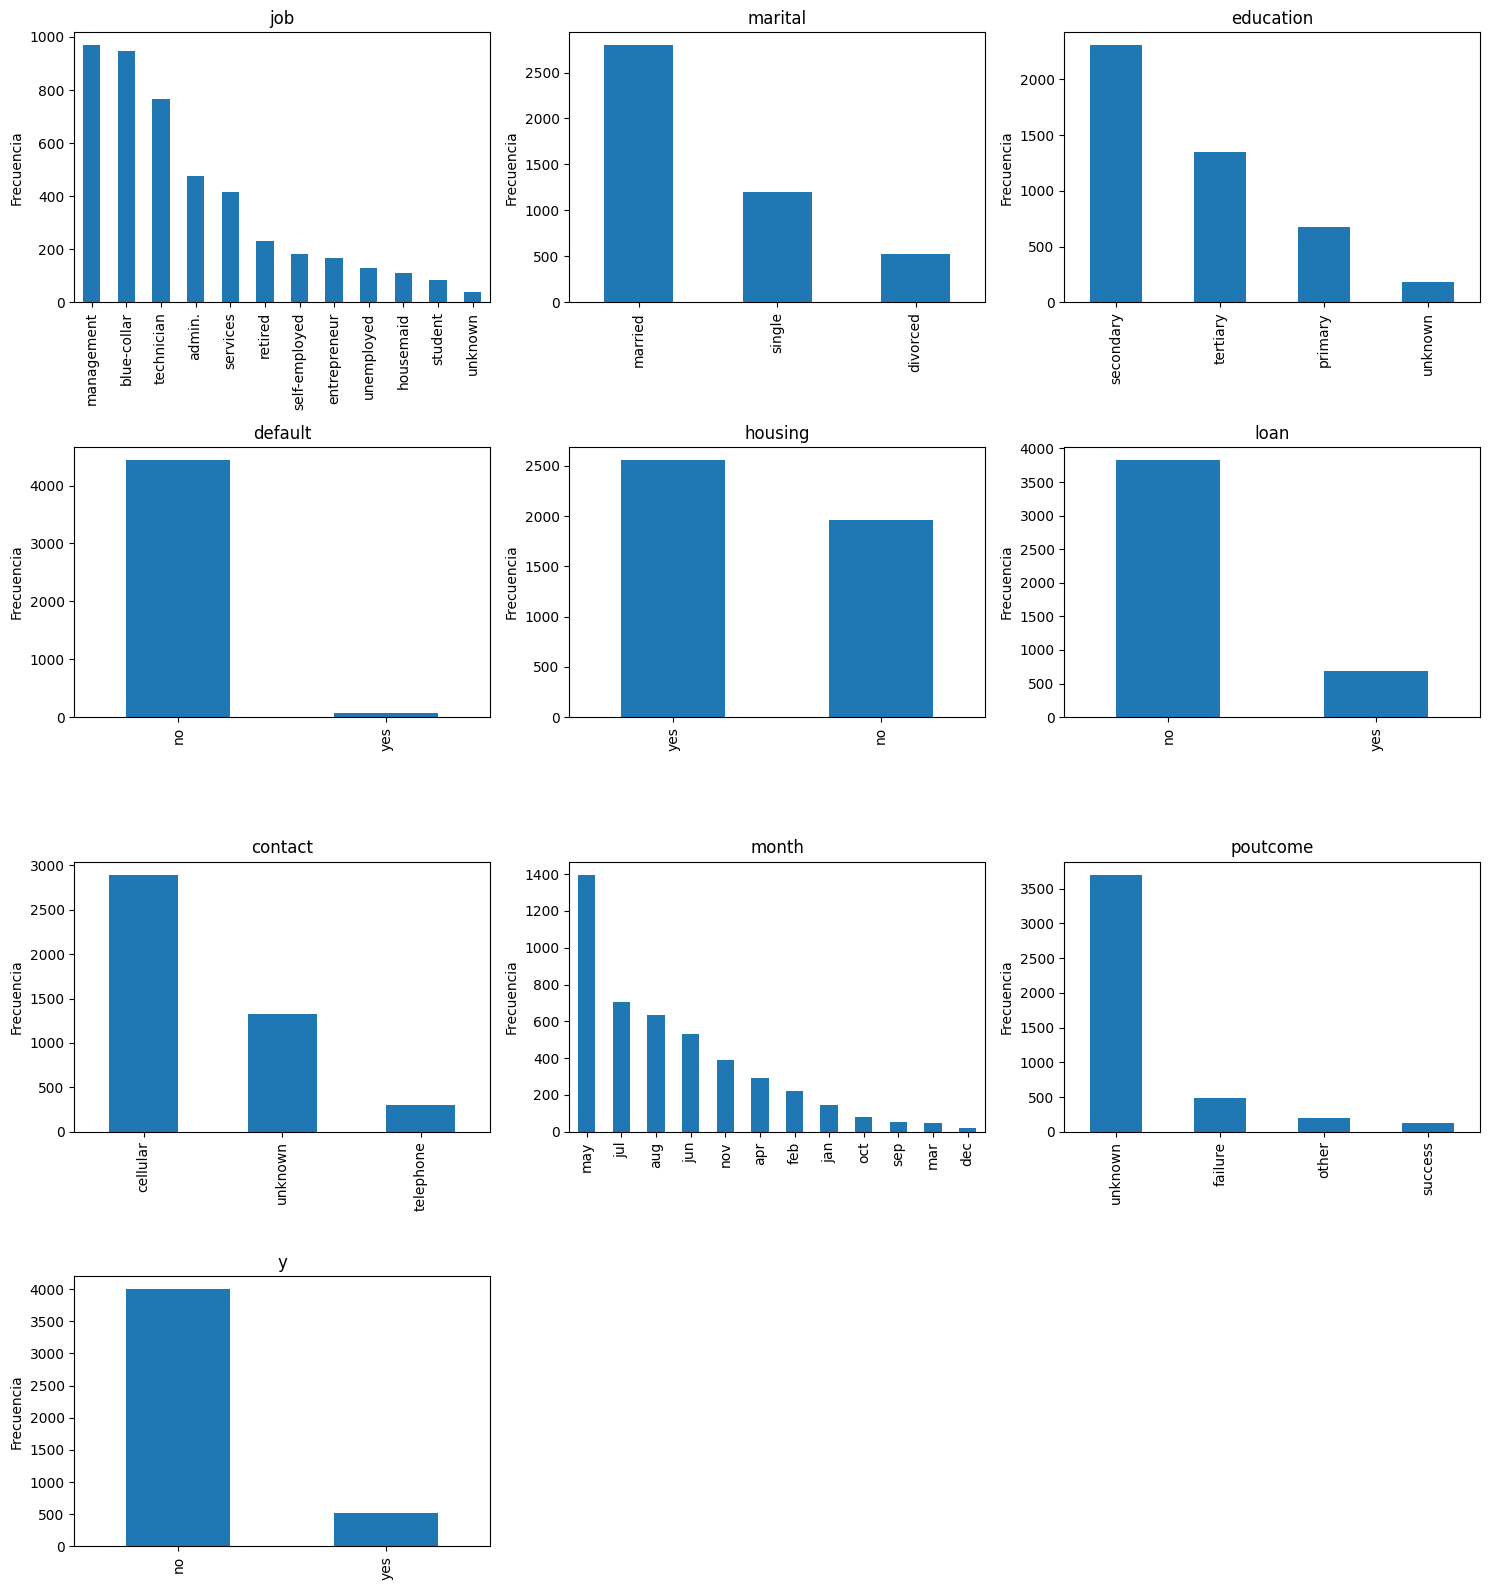

In [9]:
# Columnas categóricas
cols_cat = df.select_dtypes(include='object').columns

n = len(cols_cat)
n_cols = 3
n_rows = int(np.ceil(n / n_cols))

fig, axes = plt.subplots(n_rows, n_cols, figsize=(5*n_cols, 4*n_rows))
axes = axes.flatten()

for i, col in enumerate(cols_cat):
    df[col].value_counts().plot(kind='bar', ax=axes[i])
    axes[i].set_title(col)
    axes[i].set_xlabel('')
    axes[i].set_ylabel('Frecuencia')

for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


No se corrigen outliers porque la base de datos ya está limpia y no presenta valores imposibles. Además, los valores extremos observados corresponden a comportamientos reales de algunos clientes dentro de la campaña, por lo que eliminarlos podría distorsionar la información relevante para el modelo.


# 1. Análisis preliminar



## 1.1 Análisis de la variable dependiente

En nuestro caso, la variable `y` indica si el cliente contrata o no el depósito a plazo ofrecido por el banco `(y = 1 si no lo hace)`.
Es importante modelar dicha variable porque es la variable que representa el resultado que nos interesa explicar y predecir. Al construir un modelo para `y` usando las variables independientes, el banco puede estimar la probabilidad de respuesta de cada cliente, entender qué factores influyen más en esa respuesta y, en función de ello, optimizar sus campañas de marketing, priorizando a los clientes con mayor probabilidad de aceptación y utilizando mejor sus recursos comerciales.

In [16]:
# Identificamos nuestra variable dependiente y la convertimos a dummy
y = (df['y']== 'yes').astype(int)

"The data is related with direct marketing campaigns of a Portuguese banking institution. The marketing campaigns were based on phone calls. Often, more than one contact to the same client was required, in order to assess if the product (bank term deposit) would be ('yes') or not ('no') subscribed."

Dado este contexto, se han seleccionado (a propio juicio) las cinco variables regresoras más importantes (en términos de predictibilidad), usando como criterios principales la información del perfil del cliente y el desarrollo de la campaña telefónica:

* **`housing:`** indica si el cliente tiene un préstamo hipotecario. Representa una obligación financiera de largo plazo. Refleja compromisos estables que pueden limitar la capacidad del cliente para destinar recursos a productos de ahorro.

* **`loan:`** señala si el cliente posee un préstamo personal vigente. Este tipo de deuda es típicamente de corto plazo y sugiere presiones financieras inmediatas, lo que puede reducir el interés del cliente en contratar un depósito a plazo.

* **`duration:`** duración, en segundos, del último contacto telefónico de la campaña actual. Es una variable clave de la campaña, ya que llamadas más largas suelen asociarse a conversaciones más profundas y, potencialmente, a un mayor interés del cliente.

* **`campaign:`** número de contactos realizados con ese cliente durante la campaña actual. Refleja la intensidad del esfuerzo comercial. Muchos intentos pueden indicar insistencia por parte del banco, pero también posible saturación del cliente.

* **`poutcome:`** resultado de la campaña de marketing previa (success, failure o nonexistent). Aporta información histórica sobre el comportamiento del cliente y permite identificar si interacciones anteriores tuvieron éxito, lo que puede influir en su disposición actual a aceptar el producto.

Nota 1: en un principio se selecionaron otras variables explicativas del perfil del cliente (age, is_married, por ejemplo) pero resultaban muy insignificativas a la hora de correr los modelos Logit y Probit, por lo que se descartaron.

Nota 2: las variables de housing y loan podrían presentar una fuerte correlación pues ambas hacen referencia a la adquisición de deuda (mediano y largo plazo). Igual, nos son útiles para analizar el peso del perfil del usuario en contraste a las variables relacionadas a la campaña telefónica.  


In [17]:
# Regresores seleccionados
vars = ['housing', 'loan', 'duration', 'campaign', 'poutcome']

# Regresores
X = df[vars].copy()

# Convertimos categóricas a dummies 0/1
X = pd.get_dummies(X, columns=['housing', 'loan', 'poutcome'], drop_first=True, dtype=int)

X.head()

,duration,campaign,housing_yes,loan_yes,poutcome_other,poutcome_success,poutcome_unknown
0,79,1,0,0,0,0,1
1,220,1,1,1,0,0,0
2,185,1,1,0,0,0,0
3,199,4,1,1,0,0,1
4,226,1,1,0,0,0,1


## 1.2 Análisis exploratorio

En las `variables numéricas` se observan los siguientes patrones principales:

* **`duration:`** la duración promedio de las llamadas es de 4 minutos, con una mediana de 3.5 minutos. Esto indica que la mayoría de llamadas son relativamente cortas, aunque existen algunos casos de conversaciones mucho más largas (hasta 50 minutos aprox.), lo que genera una distribución fuertemente asimétrica a la derecha. Estos valores extremos representan situaciones reales dentro de la campaña.

* **`campaign:`** el número de contactos por cliente tiene un promedio de 2.79 y una mediana de 2. La mayoría de personas fueron contactadas pocas veces, mientras que algunos casos alcanzan hasta 50 intentos (puede deberse a clientes difíciles de contactar o campañas especialmente insistentes para ciertos perfiles). Al igual que duration, presenta una distribución sesgada a la derecha, lo cual refleja pocos clientes con un número elevado de contactos.

En conjunto, ambas variables muestran concentraciones en valores bajos y colas largas hacia la derecha, consistentes con el comportamiento típico de campañas telefónicas.


In [18]:
nume_vars = ['duration', 'campaign']

desc = X[nume_vars].describe().T
desc

,count,mean,std,min,25%,50%,75%,max
duration,4521.0,263.961292,259.856633,4.0,104.0,185.0,329.0,3025.0
campaign,4521.0,2.793630,3.109807,1.0,1.0,2.0,3.0,50.0


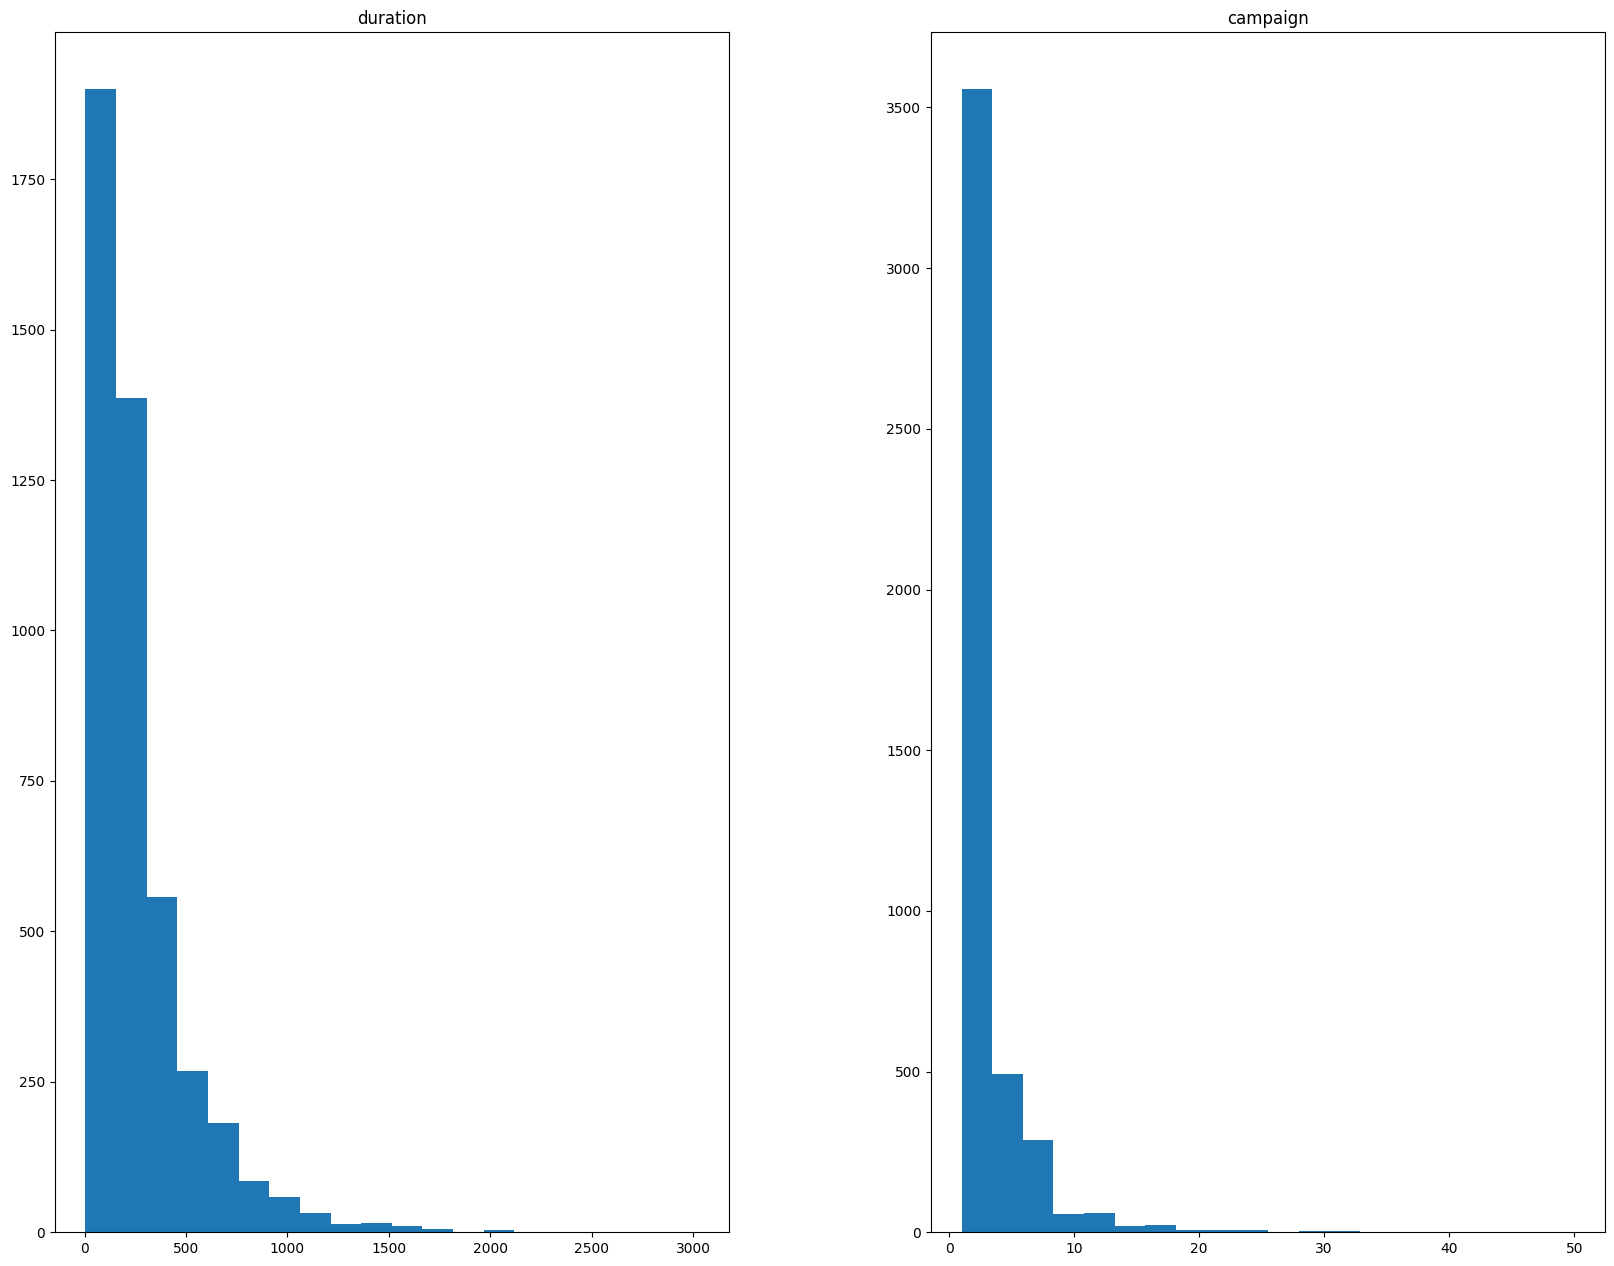

In [19]:
# Histogramas de las variables numéricas
Histogramas(columns=nume_vars, ncols= 2, dataframe = X) # vemos la asimetría (positive skew)

Ahora, en cuanto a las `variables categóricas` seleccionadas se observan las siguientes proporciones:

* **`housing_yes:`** cerca del 56% de los clientes tiene una hipoteca, lo que indica una presencia importante de obligaciones financieras de largo plazo dentro de la muestra.

* **`loan_yes:`** solo alrededor del 15% posee un préstamo personal, lo que refleja que las deudas de corto plazo son menos frecuentes que las hipotecas.

* **`poutcome_other:`** aproximadamente el 4% de los clientes tuvo un resultado previo distinto a "success" o "unknown", por lo que esta categoría es relativamente poco común.

* **`poutcome_succes:`** apenas el 2.8% presenta un resultado exitoso en campañas anteriores, lo que confirma que el éxito previo es un evento raro pero muy informativo.

* **`poutcome_unknown:`** cerca del 82% no tiene información previa de campañas, lo que demuestra que en la mayoría de casos no hubo contactos anteriores.

En conjunto, la muestra se caracteriza principalmente por una alta proporción de clientes sin historial previo de campañas y por una mayor presencia de deudas hipotecarias frente a deudas personales.

In [20]:
cat_vars = ['housing_yes', 'loan_yes',	'poutcome_other',	'poutcome_success',	'poutcome_unknown']

prop_df = pd.concat({col: X[col].value_counts(normalize=True) for col in cat_vars},axis=1).T

prop_df

,1,0
housing_yes,0.566025,0.433975
loan_yes,0.152842,0.847158
poutcome_other,0.043574,0.956426
poutcome_success,0.028534,0.971466
poutcome_unknown,0.819509,0.180491


## 1.3 Análisis de correlación

En la matriz de correlación se observa que  

* **`duration`** es la variable con mayor relación con la variable dependiente (`y`), con una correlación positiva y moderada (aprox. 0.40). Esto es coherente con lo observado previamente: llamadas más largas suelen asociarse con una mayor probabilidad de aceptación del depósito.

* Otras variables como **`poutcome_success`** muestran una correlación positiva (0.28), lo que indica que clientes con campañas previas exitosas tienden a aceptar nuevamente. En cambio, **`poutcome_unknown`** presenta una correlación negativa, reflejando menor probabilidad de conversión cuando no existe historial previo.

* Variables como **`campaign`**, **`housing_yes`** y **`loan_yes`** presentan correlaciones bajas, aunque esto no significa que no sean relevantes. Su aporte está más vinculado al contenido económico que representan que a su correlación lineal simple.

* Finalmente, es importante recordar que **la correlación no implica causalidad**, por lo que estos valores no determinan el efecto real de cada variable en la decisión del cliente.

**Nota:** En cuanto a la multicolinealidad, `housing_yes` y `loan_yes` no presentan relación significativa entre sí. Las dummies de `poutcome`, en cambio, sí muestran correlaciones moderadas, lo cual es completamente normal porque representan categorías mutuamente excluyentes.


Text(0.5, 1.0, 'Correlation Heatmap')

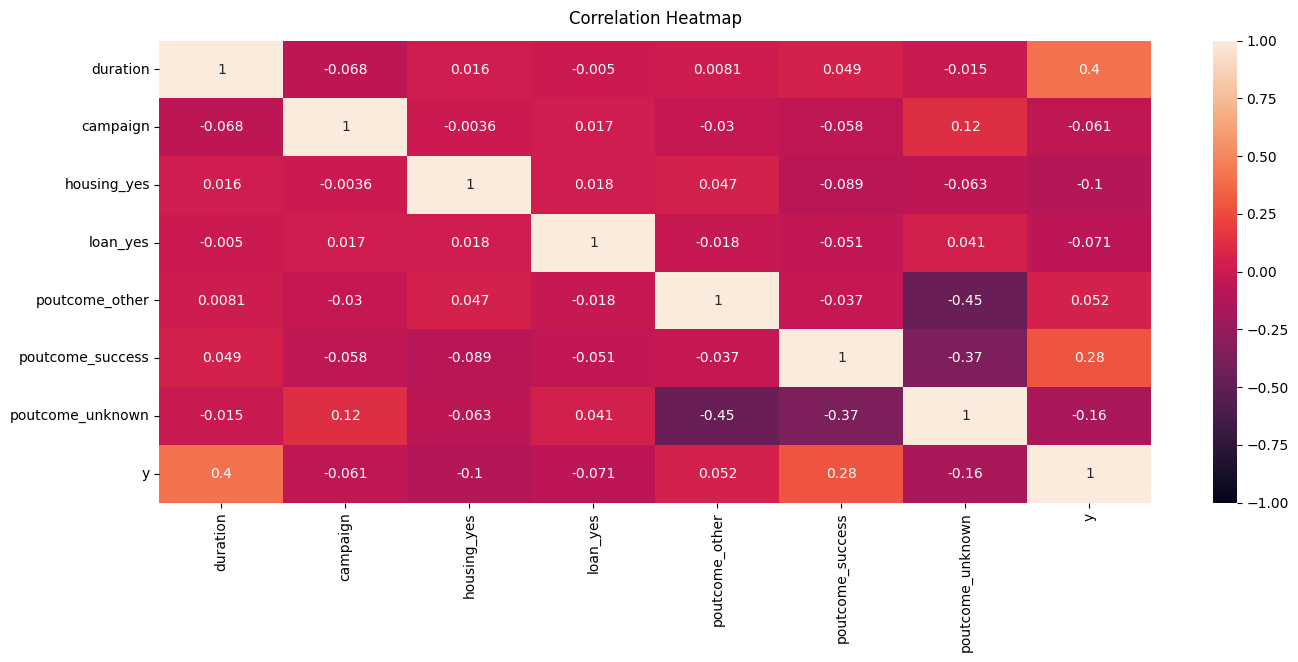

In [21]:
# DF con las variables
regs = ['duration',	'campaign',	'housing_yes',	'loan_yes',	'poutcome_other',	'poutcome_success',	'poutcome_unknown']

data_corr = X[regs].copy()
data_corr['y'] = y

corr = data_corr.corr()

# Matriz de correlaciones
plt.figure(figsize=(16, 6))

heatmap = sns.heatmap(corr, vmin=-1, vmax=1, annot=True)
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':12}, pad=12)

# 2. Modelo Logit/Probit

In [22]:
# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y, test_size=0.3, random_state=1905)

Los modelos Logit y Probit muestran resultados consistentes, pues la mayoría de las variables seleccionadas resultan altamente significativas y con los signos esperados.

La única variable con significancia limitada es **`poutcome_other`**, cuyo coeficiente es positivo pero con un p-valor cercano al umbral.

En general, ambos modelos confirman la relevancia de las variables elegidas y la estabilidad de los resultados.


In [23]:
# Ajustar el modelo logit
logit_model = sm.Logit(y_train, sm.add_constant(X_train))
logit_result = logit_model.fit()

# Resumen del modelo logit
print(logit_result.summary())

Optimization terminated successfully.
         Current function value: 0.263614
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                 3164
Model:                          Logit   Df Residuals:                     3156
Method:                           MLE   Df Model:                            7
Date:                Sun, 07 Dec 2025   Pseudo R-squ.:                  0.2628
Time:                        01:53:23   Log-Likelihood:                -834.08
converged:                       True   LL-Null:                       -1131.4
Covariance Type:            nonrobust   LLR p-value:                3.544e-124
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const               -2.4027      0.211    -11.369      0.000      -2.817      -1.988
duration   

In [24]:
# Ajustar el modelo probit
probit_model = sm.Probit(y_train, sm.add_constant(X_train))
probit_result = probit_model.fit()

# Resumen del modelo probit
print(probit_result.summary())

Optimization terminated successfully.
         Current function value: 0.261834
         Iterations 7
                          Probit Regression Results                           
Dep. Variable:                      y   No. Observations:                 3164
Model:                         Probit   Df Residuals:                     3156
Method:                           MLE   Df Model:                            7
Date:                Sun, 07 Dec 2025   Pseudo R-squ.:                  0.2678
Time:                        01:53:23   Log-Likelihood:                -828.44
converged:                       True   LL-Null:                       -1131.4
Covariance Type:            nonrobust   LLR p-value:                1.330e-126
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const               -1.3715      0.111    -12.364      0.000      -1.589      -1.154
duration   

## 2.2 Análisis de efectos marginales

Hacemos uso de las elasticidades para interpretar los efectos de variables continuas, ya que un cambio porcentual en estas resulta significativo y fácil de interpretar.

* **`duration`** presenta la elasticidad más alta. Un aumento de 1% en la duración (por ejemplo, una llamada ligeramente más larga) incrementa la probabilidad de aceptación en alrededor de 1.04%.

Para variables discretas como **`campaign`** y para las dummies, un cambio porcentual no tiene interpretación práctica, por lo que no pueden analizarse mediante elasticidades.


In [25]:
margeff_1 = probit_result.get_margeff(at='mean', method='eyex')
print(margeff_1.summary())

       Probit Marginal Effects       
Dep. Variable:                      y
Method:                          eyex
At:                              mean
                 d(lny)/d(lnx)    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
duration                1.0248      0.063     16.238      0.000       0.901       1.148
campaign               -0.1746      0.084     -2.083      0.037      -0.339      -0.010
housing_yes            -0.4357      0.076     -5.728      0.000      -0.585      -0.287
loan_yes               -0.1115      0.033     -3.355      0.001      -0.177      -0.046
poutcome_other          0.0192      0.014      1.396      0.163      -0.008       0.046
poutcome_success        0.0646      0.009      6.974      0.000       0.046       0.083
poutcome_unknown       -0.5641      0.161     -3.496      0.000      -0.880      -0.248


En el caso de las variables dummy, los efectos marginales se interpretan como diferencias en probabilidad respecto al grupo base.
En las dummies de `poutcome`, la categoría base corresponde a **`poutcome = failure`**, al ser la única que no está codificada explícitamente.

* **`housing_yes`**: tener hipoteca reduce la probabilidad de aceptación en aproximadamente 5.6 p.p. respecto al grupo que no tiene hipoteca.

* **`loan_yes`**: contar con un préstamo personal disminuye la probabilidad en unos 5.3 p.p. frente a quienes no tienen préstamo.

* **`poutcome_success`**: aumenta la probabilidad en cerca de 16 p.p. respecto al grupo base (`failure`).

* **`poutcome_unknown`**: reduce la probabilidad en alrededor de 4.9 p.p. frente al grupo base (`failure`).

* **`poutcome_other`**: incrementa la probabilidad en unos 3.1 p.p., aunque este efecto no es estadísticamente significativo.


In [26]:
margeff_2 = probit_result.get_margeff(at='mean', method='dydx')
print(margeff_2.summary())

       Probit Marginal Effects       
Dep. Variable:                      y
Method:                          dydx
At:                              mean
                      dy/dx    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
duration             0.0003   1.69e-05     16.111      0.000       0.000       0.000
campaign            -0.0045      0.002     -2.123      0.034      -0.009      -0.000
housing_yes         -0.0559      0.009     -5.947      0.000      -0.074      -0.037
loan_yes            -0.0530      0.015     -3.433      0.001      -0.083      -0.023
poutcome_other       0.0310      0.022      1.397      0.162      -0.012       0.074
poutcome_success     0.1608      0.024      6.594      0.000       0.113       0.209
poutcome_unknown    -0.0492      0.014     -3.532      0.000      -0.077      -0.022


# 3. Árboles de decisión

Sin un proceso adecuado de `GridSearch`, el árbol resultante se vuelve excesivamente complejo (25 niveles y 507 hojas). Aunque este modelo puede ser eficiente en términos de ajuste, pierde utilidad práctica, ya que nuestro objetivo es obtener un árbol interpretable y fácil de analizar.


In [27]:
# Decision Tree
tree = DecisionTreeClassifier()
tree.fit(X_train, y_train)

print("Profundidad del árbol:", tree.get_depth())
print("Número de hojas:", tree.get_n_leaves())
print("Importancia de las características:", tree.feature_importances_)

Profundidad del árbol: 25
Número de hojas: 507
Importancia de las características: [0.66101457 0.13176938 0.05336808 0.02291678 0.01025666 0.09496868
 0.02570584]


El árbol óptimo (profundidad 2) muestra que los factores más influyentes en la clasificación son la **`duration`** de la llamada y el **`poutcome_success`**, generando divisiones con buena pureza pese a la baja tasa general de aceptación.

* **Nodo izquierdo:** cuando la **`duration`** es baja y no hubo éxito previo (**`poutcome_success = 0`**), la mayoría de los clientes se clasifican como “no”, con gini bajo y alta pureza.

* **Nodo derecho:** para valores más altos de **`duration`**, aumenta la proporción de casos “yes”, especialmente al superar el segundo umbral, aunque los nodos muestran algo más de mezcla.


Mejore parámetro: {'max_depth': 2}
Mejor accuracy CV: 0.8982337472753814
Accuracy en test: 0.8960943257184967


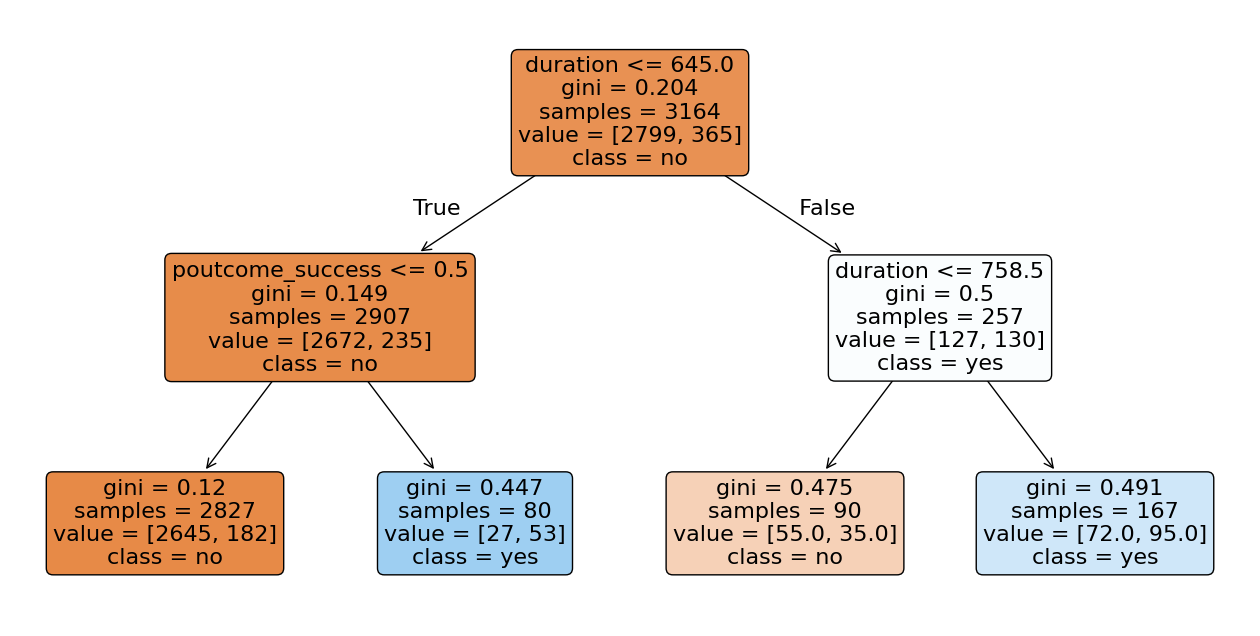

In [28]:
# Grid search - 5 valores de profundidad
param_grid = {'max_depth': [2, 3, 4, 5, 6]}
tree = DecisionTreeClassifier(random_state=1905)
grid_search = GridSearchCV(tree, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

print("Mejore parámetro:", grid_search.best_params_)
print("Mejor accuracy CV:", grid_search.best_score_)

# Árbol óptimo
best_tree = grid_search.best_estimator_

# Evaluación en test
y_pred = best_tree.predict(X_test)
print("Accuracy en test:", accuracy_score(y_test, y_pred))

# Gráfica del Árbol
plt.figure(figsize=(16, 8))
plot_tree(best_tree, feature_names=X.columns, class_names=['no', 'yes'], filled=True, rounded=True)
plt.show()

# 4. Random Forest


In [29]:
# Modelo de Random Forest
model = RandomForestClassifier(n_estimators=400, max_depth=None, min_samples_leaf=2, random_state=1905, n_jobs=-1)
model.fit(X_train, y_train)

RandomForestClassifier(min_samples_leaf=2, n_estimators=400, n_jobs=-1,
                       random_state=1905)

In [30]:
# Crear el explicador SHAP para el Random Forest
explainer = shap.TreeExplainer(model)

X_sample = X_test

shap_values = explainer.shap_values(X_sample)


El gráfico SHAP muestra cómo cada variable desplaza la predicción desde el valor base **E[f(X)] = 0.115** hacia el resultado final para esta observación. Vemos que el resultado está fuertemente determinado por la baja duración de la llamada, que desplaza la predicción hacia una probabilidad menor de aceptar el depósito. El resto de variables actúan como ajustes pequeños alrededor de esa contribución principal.

- **`duration = 31` → –0.12**  
  La duración extremadamente corta de la llamada (31 segundos) es el factor más influyente y reduce de forma considerable la probabilidad estimada de aceptar el depósito.

- **`housing_yes` → +0.02**  
  Tener un crédito hipotecario aporta un leve aumento en la probabilidad, posiblemente asociado a mayor estabilidad financiera o mayor relación con el banco.

- **`poutcome_success = 0` → –0.01**  
  No haber tenido éxito en campañas anteriores reduce ligeramente la probabilidad, en línea con el historial previo del cliente.

- **`campaign = 1` → +0.01**  
  Un número reducido de contactos genera un pequeño aumento en la probabilidad, quizás porque el cliente aún no ha mostrado señales claras de rechazo.

- **`loan_yes`, `poutcome_unknown`, `poutcome_other` → efecto prácticamente nulo**  
  Su influencia en la predicción es mínima para esta observación.


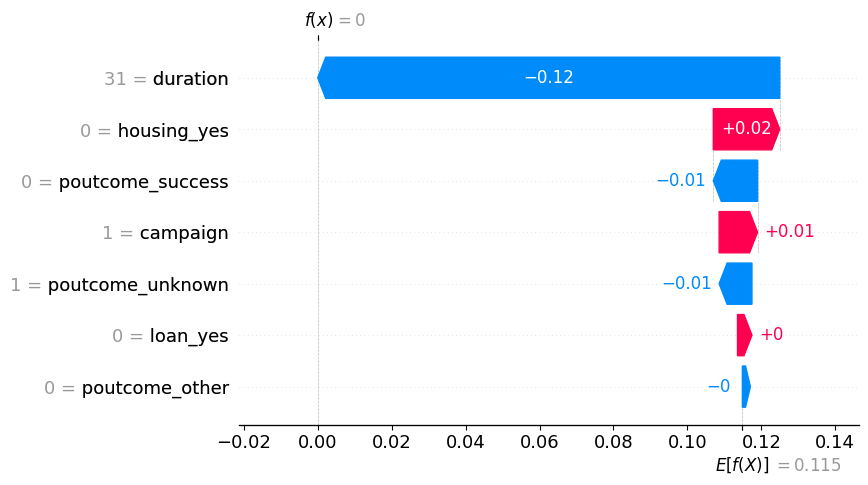

In [31]:
sample_index = 10
# Crear el gráfico de waterfall
shap.waterfall_plot(
    shap.Explanation(
        values=shap_values[sample_index,:,1],  # Valores SHAP para la predicción de la clase 1
        base_values=explainer.expected_value[1],  # Valor base del modelo
        data=X_test.iloc[sample_index]  # Valores de las características para la observación
    )
)

En este caso, la probabilidad final es menor (0.046), principalmente debido a la **duración moderadamente baja de la llamada** y a la ausencia de ciertos atributos favorables. Las demás variables generan ajustes pequeños que complementan ese efecto principal.

- **`duration = 124` → –0.06**  
  Aunque la llamada es más larga que en el caso anterior, sigue siendo relativamente corta, lo que reduce la probabilidad de aceptación. Su efecto sigue siendo el más influyente.

- **`campaign = 1` → +0.04**  
  Haber sido contactado una sola vez incrementa moderadamente la probabilidad, posiblemente porque todavía no hay señales de rechazo por saturación del cliente.

- **`housing_yes = 0` → –0.03**  
  No tener un crédito hipotecario resta probabilidad, ya que puede interpretarse como un menor grado de vinculación o estabilidad financiera con la entidad.

- **`poutcome_success = 0` → –0.01**  
  No haber tenido éxito previo en campañas disminuye ligeramente la probabilidad, reflejando un historial menos favorable.

- **`loan_yes = 0` → +0.01**  
  No contar con un préstamo personal aporta un aumento pequeño, asociado a menor nivel de obligaciones financieras.

- **`poutcome_unknown`, `poutcome_other` → efecto prácticamente nulo**  
  Su influencia es mínima para esta observación.


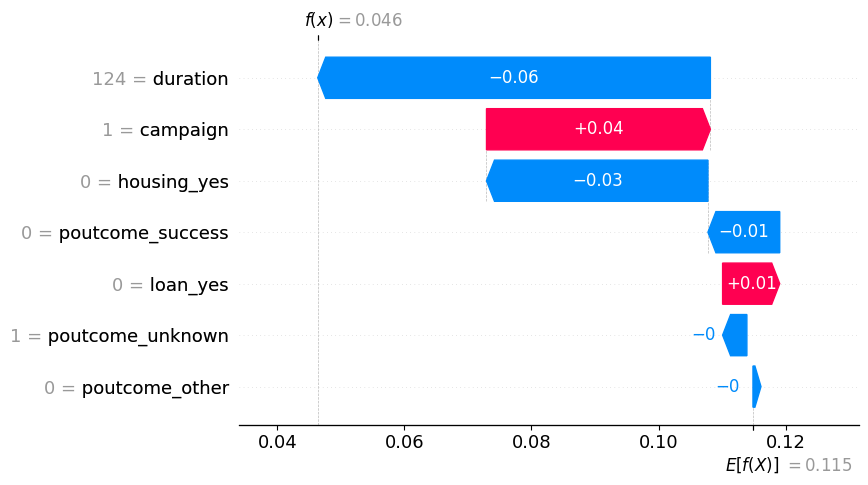

In [32]:
sample_index = 19
# Crear el gráfico de waterfall
shap.waterfall_plot(
    shap.Explanation(
        values=shap_values[sample_index,:,1],  # Valores SHAP para la predicción de la clase 1
        base_values=explainer.expected_value[1],  # Valor base del modelo
        data=X_test.iloc[sample_index]  # Valores de las características para la observación
    )
)

El gráfico de importancia SHAP muestra que **`duration`** es, por amplio margen, la variable que más influye en las predicciones del Random Forest. Le siguen **`housing_yes`**, **`poutcome_unknown`** y **`campaign`**. Por su parte, **`loan_yes`** y **`poutcome_other`** tienen un efecto promedio mucho menor sobre la salida del modelo.v

Vemos que los resultados reafirman que la duración de la llamada es el principal determinante en la clasificación, mientras que el resto de variables aportan ajustes más pequeños.


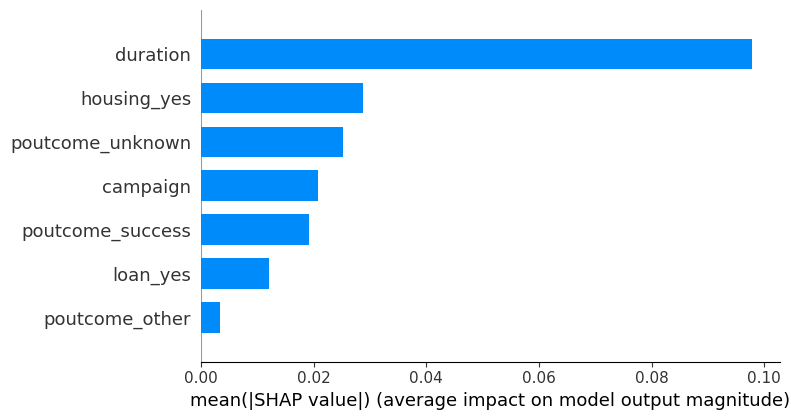

In [33]:
# Gráfico de importancia de las características basado en SHAP
shap.summary_plot(shap_values[:, :, 1], X_sample, plot_type="bar", feature_names=X_sample.columns)

# 5. Análisis comparativo

## Matrices de confusión

En general, los cuatro modelos muestran buen desempeño para identificar a los clientes que **no** aceptan el depósito, con tasas altas de verdaderos negativos. Sin embargo, todos presentan dificultades para detectar correctamente los casos **sí**, aunque con diferencias claras:

* **Logit y Probit** son los más conservadores: casi no predicen “sí”, por lo que tienen pocos falsos positivos pero también pocos aciertos en la clase positiva.
* **Decision Tree** mejora la detección de “sí”, aunque al costo de aumentar los falsos positivos.
* **Random Forest** logra el mejor equilibrio: incrementa los aciertos en la clase positiva respecto a Logit/Probit y reduce errores frente al árbol simple.

En conjunto, el Random Forest entrega el desempeño predictivo más sólido entre los cuatro modelos.


In [34]:
# Predicciones de los modelos usados
y_pred_logit = (logit_result.predict(sm.add_constant(X_test)) > 0.5).astype(int)
y_pred_probit = (probit_result.predict(sm.add_constant(X_test)) > 0.5).astype(int)
y_pred_tree = best_tree.predict(X_test)
y_pred_rf = model.predict(X_test)

# Matrices de confusión
cm_logit  = confusion_matrix(y_test, y_pred_logit)
cm_probit = confusion_matrix(y_test, y_pred_probit)
cm_tree   = confusion_matrix(y_test, y_pred_tree)
cm_rf     = confusion_matrix(y_test, y_pred_rf)

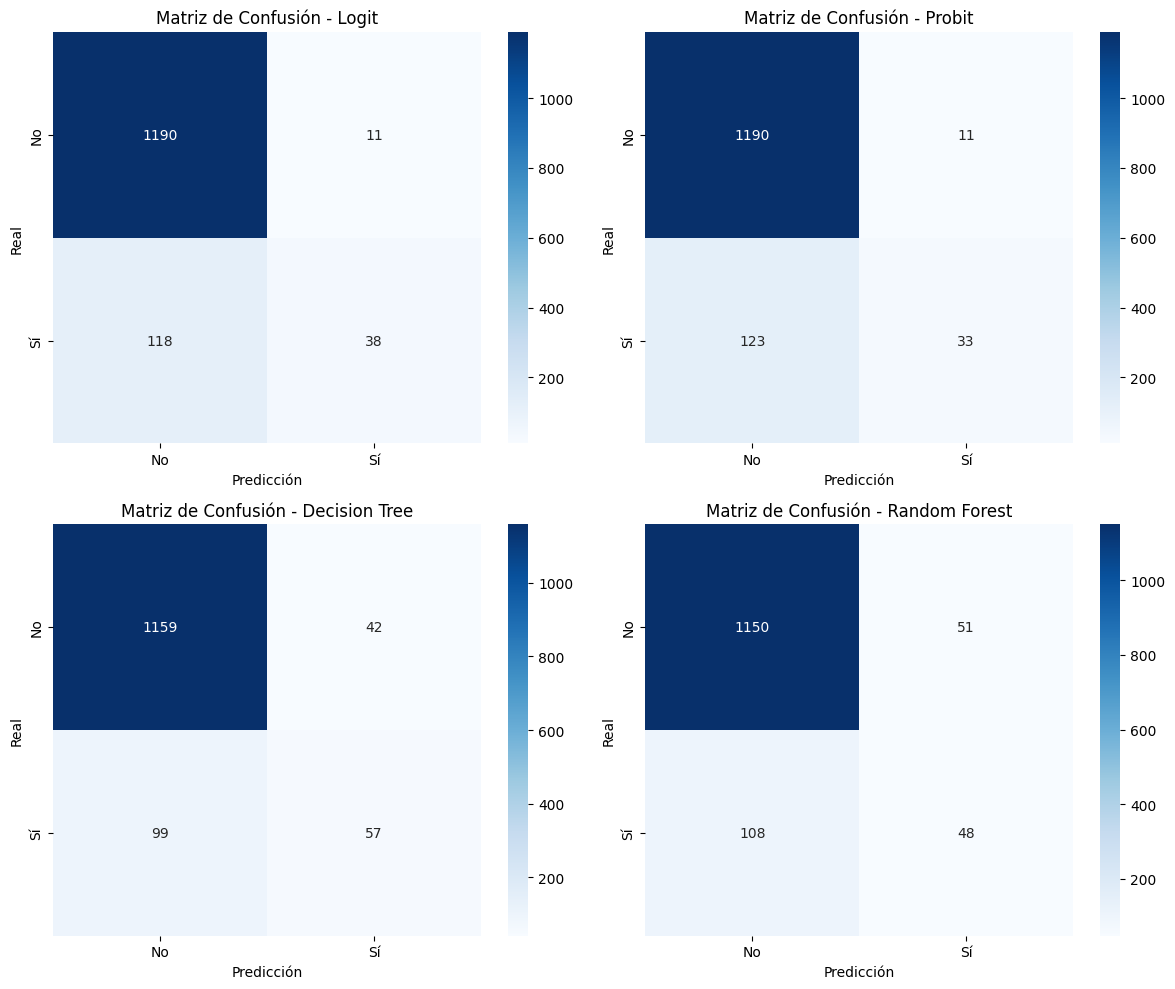

In [35]:
# Gráficos

fig, axes = plt.subplots(2, 2, figsize=(12, 10))

titles = ["Logit", "Probit", "Decision Tree", "Random Forest"]
cms = [cm_logit, cm_probit, cm_tree, cm_rf]

for ax, cm, title in zip(axes.flat, cms, titles):
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=["No", "Sí"], yticklabels=["No", "Sí"], ax=ax)
    ax.set_title(f"Matriz de Confusión - {title}")
    ax.set_xlabel("Predicción")
    ax.set_ylabel("Real")

plt.tight_layout()
plt.show()


## Curva ROC

* Las curvas ROC muestran que **Logit** y **Probit** alcanzan el mejor desempeño global (ambos AUC de **0.854**). Esto evidencia una buena capacidad discriminativa entre clientes que aceptan y no aceptan el depósito.

* El **Random Forest** obtiene un AUC ligeramente menor (**0.817**), pero aun así competitivo y superior al árbol simple. Su curva muestra mejor desempeño que el Decision Tree en casi todo el rango de la FPR.

* El **Árbol de decisión** es el modelo más débil (AUC = **0.710**), con menor habilidad para separar ambas clases.

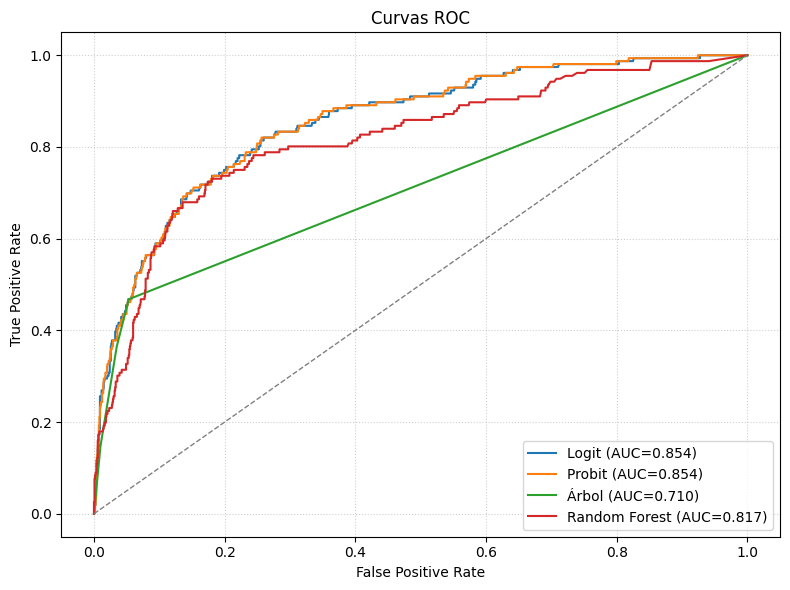

In [36]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

# Probabilidades
p_logit  = logit_result.predict(sm.add_constant(X_test))
p_probit = probit_result.predict(sm.add_constant(X_test))
p_tree   = best_tree.predict_proba(X_test)[:, 1]
p_rf     = model.predict_proba(X_test)[:, 1]

# Curvas ROC
fpr_logit,  tpr_logit,  _ = roc_curve(y_test, p_logit)
fpr_probit, tpr_probit, _ = roc_curve(y_test, p_probit)
fpr_tree,   tpr_tree,   _ = roc_curve(y_test, p_tree)
fpr_rf,     tpr_rf,     _ = roc_curve(y_test, p_rf)

auc_logit  = roc_auc_score(y_test, p_logit)
auc_probit = roc_auc_score(y_test, p_probit)
auc_tree   = roc_auc_score(y_test, p_tree)
auc_rf     = roc_auc_score(y_test, p_rf)

# Plot único
plt.figure(figsize=(8,6))
plt.plot(fpr_logit,  tpr_logit,  label=f"Logit (AUC={auc_logit:.3f})")
plt.plot(fpr_probit, tpr_probit, label=f"Probit (AUC={auc_probit:.3f})")
plt.plot(fpr_tree,   tpr_tree,   label=f"Árbol (AUC={auc_tree:.3f})")
plt.plot(fpr_rf,     tpr_rf,     label=f"Random Forest (AUC={auc_rf:.3f})")
plt.plot([0,1], [0,1], "--", linewidth=1, color="gray")

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Curvas ROC")
plt.legend(loc="lower right")
plt.grid(True, linestyle=":", alpha=0.6)
plt.tight_layout()
plt.show()


## Reporte de clasificación

In [37]:
def m(y, yhat):
    return [accuracy_score(y, yhat), precision_score(y, yhat), recall_score(y, yhat), f1_score(y, yhat)]

metrics_df = pd.DataFrame({
    "Logit": m(y_test, y_pred_logit),
    "Probit": m(y_test, y_pred_probit),
    "Árbol": m(y_test, y_pred_tree),
    "Random Forest": m(y_test, y_pred_rf),
}, index=["Accuracy","Precision","Recall","F1"]).T

metrics_df

,Accuracy,Precision,Recall,F1
Logit,0.904937,0.775510,0.243590,0.370732
Probit,0.901253,0.750000,0.211538,0.330000
Árbol,0.896094,0.575758,0.365385,0.447059
Random Forest,0.882830,0.484848,0.307692,0.376471


**Entonces, ¿con cuál modelo nos quedamos?**

Considerando que existen diversas limitaciones en los modelos que no han sido exploradas y corregidas (sobre todo en los modelos de ML, como el tuneo de hiperparámetros o el feature engineering), así como problemas en la data (por ejemplo, no hicimos oversampling), los indicadores sugieren que el modelo Logit presenta el mejor desempeño predictivo.

* En primer lugar, en las curvas ROC, Logit (junto con Probit) alcanza el AUC más alto, lo que indica mayor capacidad discriminante entre quienes aceptan y no aceptan el depósito. Sin embargo, las matrices de confusión muestran que Logit y Probit son modelos conservadores: clasifican muy bien la clase “no”, con pocos falsos positivos dada la predominancia de observaciones “no”, pero esto hace que el modelo aprenda poco a predecir los “sí”, que son los que realmente importan (ello es producto de la data desbalanceada). Esto se refleja en un recall bajo en la clase “sí”, lo que reduce su F1.

* En segundo lugar, por las limitaciones computacionales de los modelos de ML, el árbol simple queda limitado a una profundidad óptima de solo 2 niveles y, junto con el desbalance de clases, genera pocas hojas y probabilidades muy discretas; esto explica su ROC “escalonada” y su AUC inferior, aunque mejora el F1 al arriesgarse a predecir más positivos. Al Random Forest le pasa algo similar, pero al promediar muchos árboles suaviza parcialmente este problema y obtiene un AUC intermedio, aunque no llega a superar al Logit. En conjunto, y casi por descarte, considerando simultáneamente ROC–AUC, matrices de confusión y métricas de clasificación, Logit es el modelo con desempeño global más sólido, aunque no necesariamente el más óptimo si se buscara un modelo listo para poner en el negocio.


Y, dado el análisis realizado, **¿qué variables predictoras realmente poseen un poder predictivo para explicar la suscripción del depósito?**

Bueno, es evidente que los resultados obtenidos apuntan a que las variables más relevantes son las ligadas a la dinámica de la campaña, más que al perfil financiero del cliente.

* En primer lugar, `duration` es claramente la variable dominante. De hecho, tiene la mayor correlación con **`y`**, es la primera partición del árbol y aparece como la de mayor importancia en los valores de SHAP. Es decir, la probabilidad de aceptar el depósito está muy marcada por cuánto dura la conversación.

* En segundo lugar, las variables de resultado de campaña previa (`poutcome_success` y, en sentido contrario, `poutcome_unknown`) también son relevantes. Muestran correlaciones con `y` notorias, pesos no menores en SHAP y en el árbol (segunda división), también `poutcome_success` mantiene una gran repercusión en los efectos marginales en niveles. Así, el historial de interacciones comerciales importa, aunque menos que la llamada actual.

Las variables de perfil financiero (`housing_yes`, `loan_yes`) y la intensidad de contacto (`campaign`) sí tienen efecto, pero más moderado. Esto sugiere que, en esta muestra, la decisión de contratar el depósito se explica más por cómo y cuándo se contacta al cliente que por diferencias fuertes en riesgo o nivel de endeudamiento. Una posible interpretación (coherente con el contexto) es que el banco ya trabajaba con una cartera de clientes filtrada en términos de riesgo, de modo que el perfil financiero varía menos y aporta menos poder predictivo que la efectividad de la campaña.